# Single gate demonstration

This notebook demonstrates the reconstruction of the cost function depending
on a single parameter used in controlled pauli rotations gates in quantum
circuits.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy.typing import NDArray

import math

from scipy.optimize import minimize

from matplotlib import pyplot as plt

## 1. Set up demo circuit(s)

In [2]:
dev = qml.device("default.qubit", wires=4, shots=None)

@qml.qnode(dev)
def complex_circuit(crx_param):
    # some unparameterized gates
    qml.Hadamard(wires=0)
    qml.RX(1.2, wires=1)
    qml.Hadamard(wires=1)
    qml.CRX(math.pi/2, wires=[1, 0])

    # this is the gate to optimize
    qml.CRX(crx_param, wires=[0, 1])

    # some more unparameterized gates 
    qml.RX(2.3, wires=0)
    qml.CNOT(wires=[1, 0])
    
    # measure qubit 0 in computational basis
    return qml.expval(qml.PauliX(0))

@qml.qnode(dev)
def rx_circuit(rx_param):
    qml.RX(rx_param, wires=0)

    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev)
def crx_circuit(crx_param):
    qml.Hadamard(wires=0)
    qml.CRX(crx_param, wires=[0, 1])

    return qml.expval(qml.PauliZ(1))

@qml.qnode(dev)
def xxx_circuit(crz_param):
    num_layers = 5
    num_qubits = 4
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            qml.RX(1, wires=qubit) # params[layer, qubit, 0]
            qml.RZ(1, wires=qubit) # params[layer, qubit, 1]
        for qubit in range(num_qubits - 2, -1, -1): # incl. start, excl. stop, step
            qml.CRZ(crz_param if layer == 1 and qubit == 0 else 1, (qubit + 1, qubit)) # params[layer, qubit, 2]
    return qml.expval(qml.PauliZ(1))

circuit = xxx_circuit
print(qml.draw(circuit)((0,)))

0: ──RX(1.00)──RZ(1.00)─────────────────────╭RZ(1.00)──RX(1.00)──RZ(1.00)───────────╭RZ(M0)──
1: ──RX(1.00)──RZ(1.00)───────────╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●───────
2: ──RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)
3: ──RX(1.00)──RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)───────────╰●─────────RX(1.00)──RZ(1.00)

───RX(1.00)──RZ(1.00)───────────╭RZ(1.00)──RX(1.00)──RZ(1.00)───────────╭RZ(1.00)──RX(1.00)
───RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)
───RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)─╭RZ(1.00)─╰●─────────RX(1.00)──RZ(1.00)
────────────╰●─────────RX(1.00)──RZ(1.00)───────────╰●─────────RX(1.00)──RZ(1.00)──────────

───RZ(1.00)───────────╭RZ(1.00)─┤     
───RZ(1.00)─╭RZ(1.00)─╰●────────┤  <Z>
──╭RZ(1.00)─╰●──────────────────┤     
──╰●────────────────────────────┤     
M0 = 
[0]


## 2. Reconstruct cost function

See [`reconstruction.py`](./reconstruction.py) for implementation details.

In [3]:
from reconstruction import reconstruct

reconstruction = reconstruct(circuit, debug=True)

y_0=0.5326850642341028
y_pi=-0.047017362178458866
y_3/2pi=-0.33898265090232516
y_2pi=-0.2592447705221337
y_3pi=-0.4392243085543897
y_7/2pi=-0.05633588593313782

d_1=-0.05320034425521987
d_2=-0.45984414119202066
d_3=0.44186512420719865
d_4=-0.6502686716968427
d_5=0.238617211688745



## 3. Find optimal parameter

See [`minimization.py`](./minimization.py) for implementation details.

In [4]:
from minimization import minimize_reconstruction

numerical_x, _ = minimize_reconstruction(reconstruction, debug=True)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.3400619091520473
             x: [ 4.825e+00]
           nit: 24
          nfev: 48
 final_simplex: (array([[ 4.825e+00],
                       [ 4.825e+00]]), array([-3.401e-01, -3.401e-01]))


## 4. Compare reconstruction with circuit

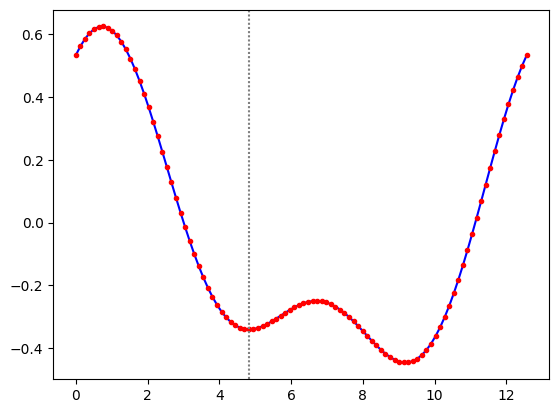

In [5]:
# initialize crx_param with 0.5 but could be any value
initial_param = (0.5,)

param = initial_param

param_values = np.linspace(0, 4 * math.pi, 100)
results = [float(circuit(p)) for p in param_values]
reconstructed_results = [reconstruction(p) for p in param_values]

fig, ax = plt.subplots()
ax.plot(param_values, results, 'b')
ax.plot(param_values, reconstructed_results, 'r.')
ax.axvline(x=numerical_x, dashes=(True,), color='gray')